In [366]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import pickle as pkl

%load_ext autoreload
%autoreload 2
from utils import *
from layers import *
from transformer import *
from cifar10 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


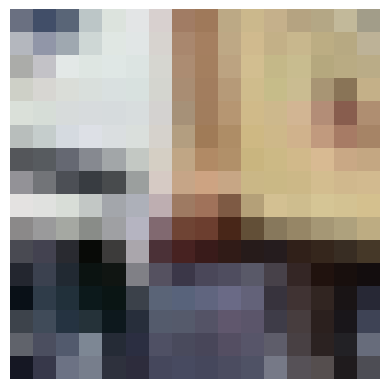

In [397]:
showimg(getimg(1))
getlabel(1)

showimg(randomcrop(getimg(1), s=16))

In [349]:

def batchgen(bsize=64, start=500):
    ep = 0
    while True:
        inds = np.random.permutation(range(start, N))
        minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
        for mb in minibatches:
            xs = []
            ys = []
            for i in mb:
                xs.append(getimg(i))
                ys.append(getlabel(i))
            yield np.array(xs), np.array(ys)
        print(f'========== EPOCH {ep} COMPLETED ==========')
        ep += 1

In [350]:
bg = batchgen()
xs, ys = next(bg)
xs.shape
sbg = sbatchgen()
xs, ys = next(sbg)
xs.shape

(64, 32, 32, 3)

In [355]:
def valloss():
    net.eval()
    xs = np.array([getimg(i) for i in range(200)])
    yt = np.array([getlabel(i) for i in range(200)])
    xs, yt = np2t(xs, yt)
    yt = yt.long()
    yp = net(xs)
    loss = F.nll_loss(F.log_softmax(yp, dim=1), yt).item()
    yp, yt = t2np(yp, yt)
    yp = yp.argmax(-1)
    acc = np.mean(yp==yt)
    return loss, acc

def sloss():
    net.train()
    xs, yt = next(sbg)
    xs, yt = np2t(xs, yt)
    yp = net(xs)
    yp = F.softmax(yp, 1)
    yt = F.softmax(yt, 1)
    return torch.mean(-torch.log(yp+1e-12) * yp)*10
    
def loss():
    net.train()
    xs, yt = next(bg)
    xs, yt = np2t(xs, yt)
    yt = yt.long()
    yp = net(xs)
    return F.nll_loss(F.log_softmax(yp, dim=1), yt)

loss()

tensor(2.4457, device='cuda:0', grad_fn=<NllLossBackward0>)

In [354]:
net = Net(128, 4)
from torch_optimizer import Lookahead, Yogi
net.optim = Lookahead(Yogi(net.parameters(), lr=3e-3))
net.iters = 0
net.losses = []
net.vlosses = []
net.slosses = []
net.vaccs = []
bg = batchgen()

from torchsummary import summary
summary(net, (32, 32, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 8, 8, 128]           6,272
PositionalEncoding2d-2            [-1, 8, 8, 128]               0
           Dropout-3              [-1, 64, 128]               0
         Embedding-4               [-1, 1, 128]             128
               TOL-5               [-1, 1, 128]               0
            Linear-6              [-1, 65, 128]          16,512
            Linear-7              [-1, 65, 128]          16,512
            Linear-8              [-1, 65, 128]          16,512
            Linear-9              [-1, 65, 128]          16,512
MultiHeadAttention-10              [-1, 65, 128]               0
          Dropout-11              [-1, 65, 128]               0
        LayerNorm-12              [-1, 65, 128]               0
           Linear-13              [-1, 65, 512]          66,048
          Dropout-14              [-

  0%|          | 0/999999 [00:00<?, ?it/s]

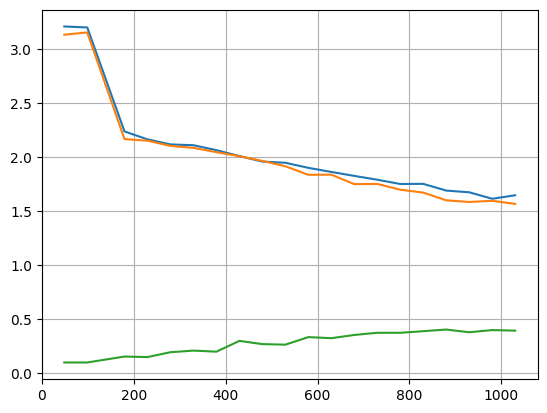

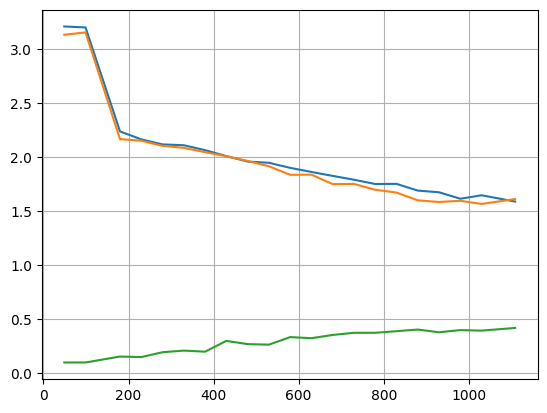

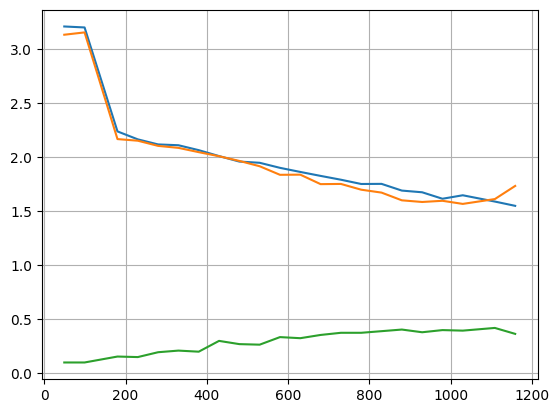

========== EPOCH 7 COMPLETED ==========


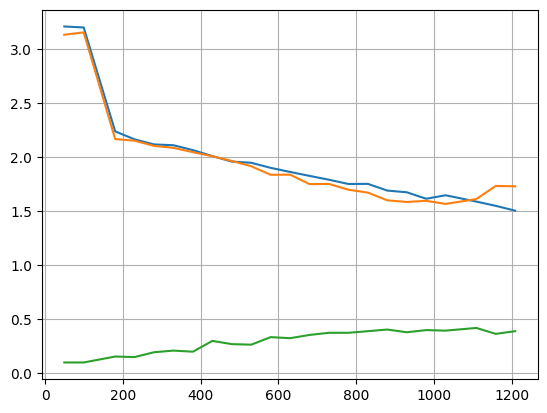

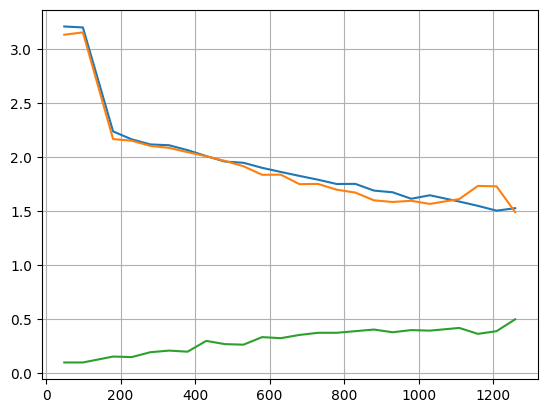

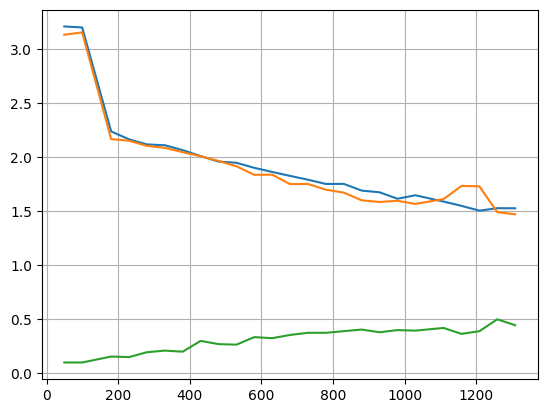

========== EPOCH 8 COMPLETED ==========


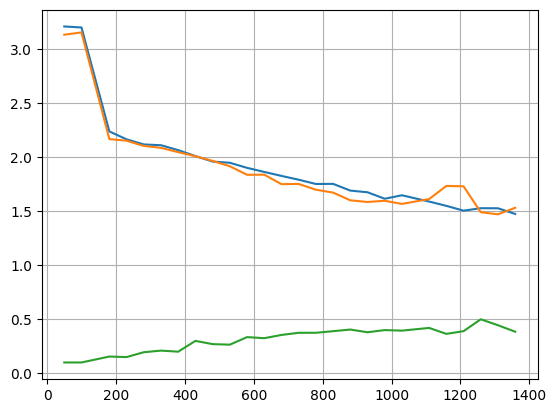

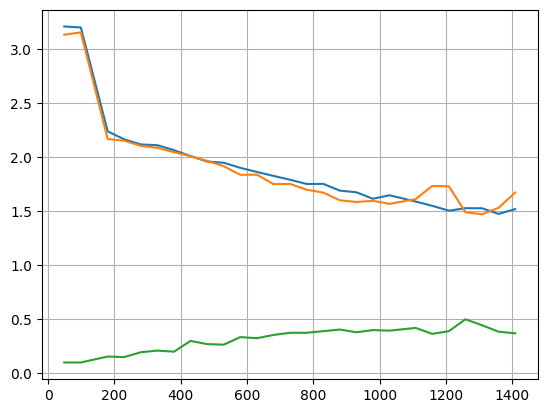

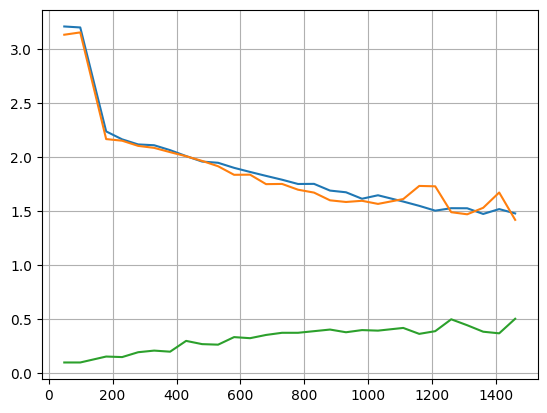

========== EPOCH 9 COMPLETED ==========


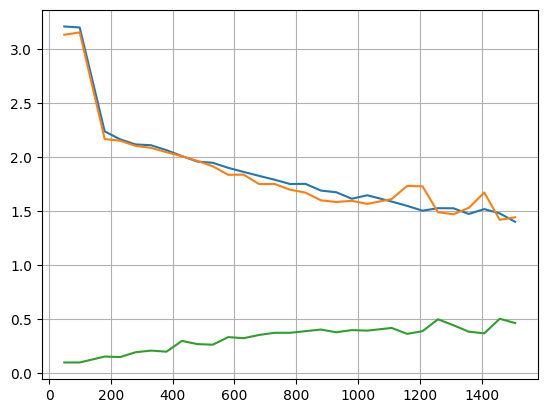

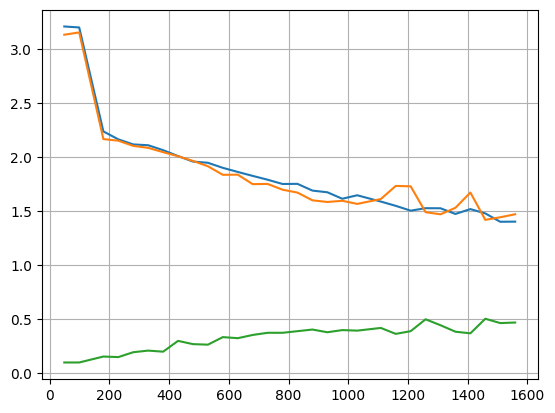

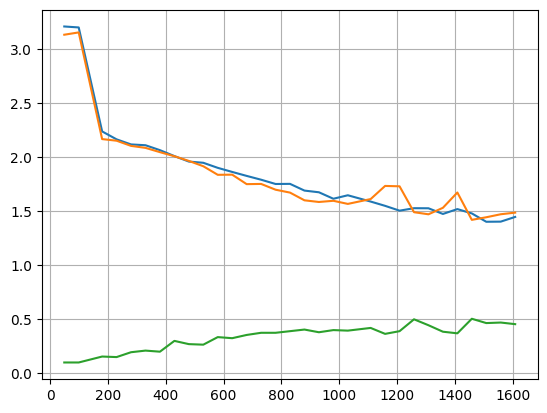

========== EPOCH 10 COMPLETED ==========


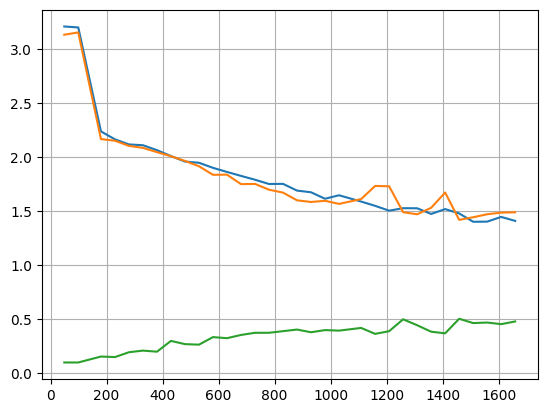

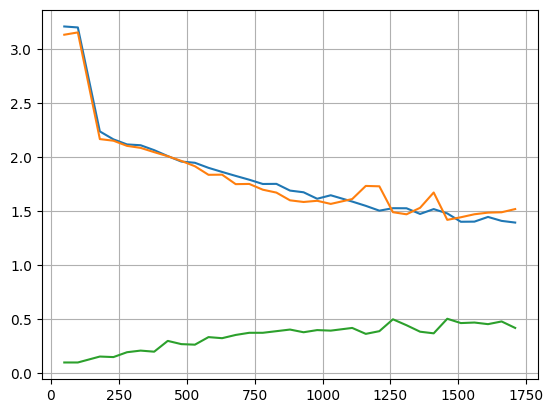

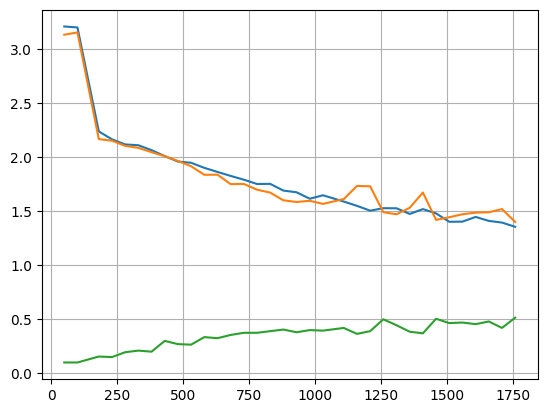

========== EPOCH 11 COMPLETED ==========


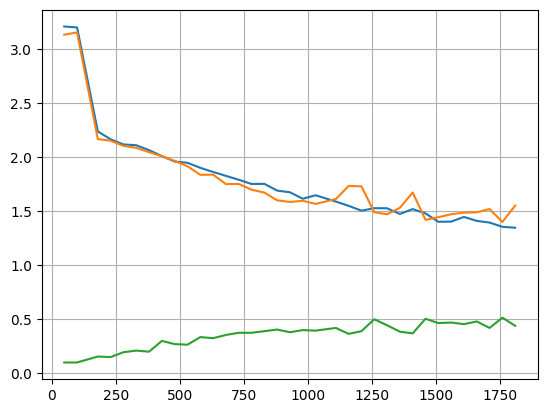

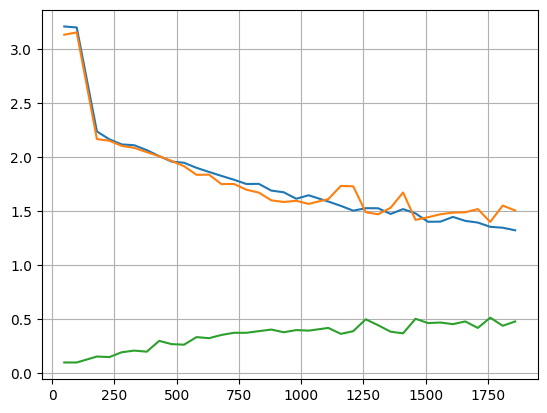

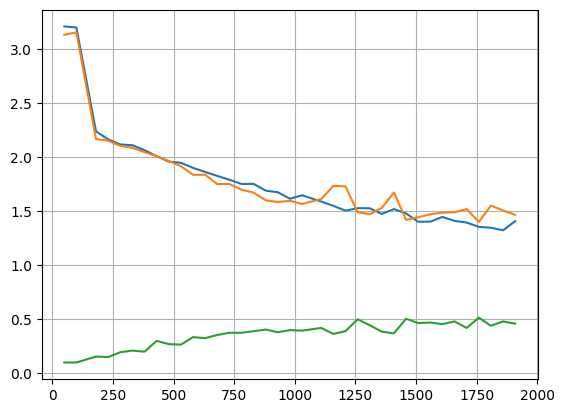

========== EPOCH 12 COMPLETED ==========


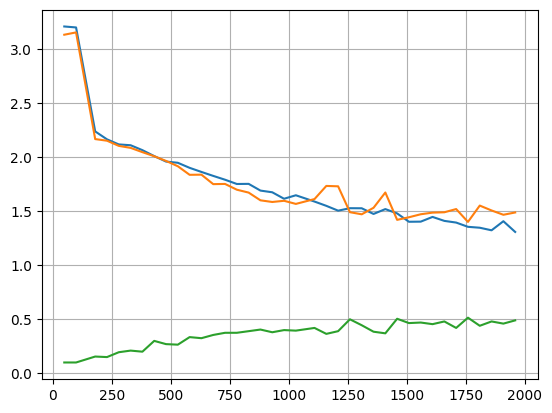

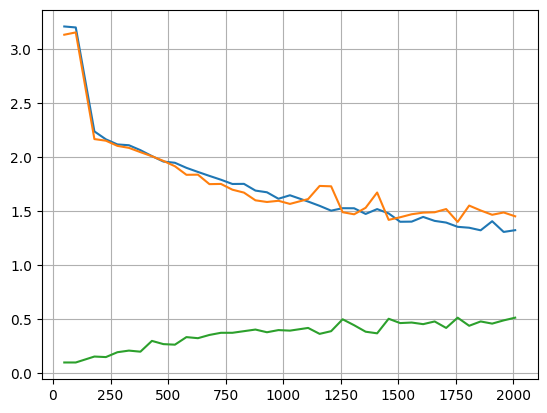

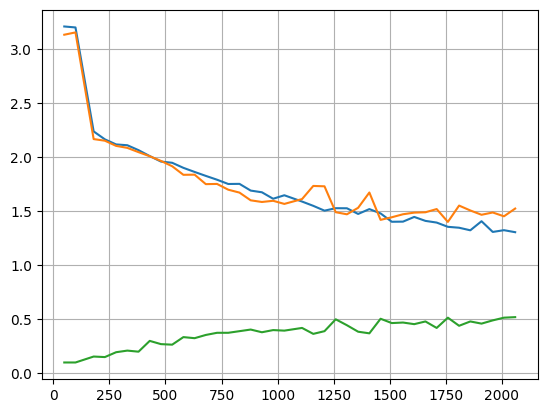

========== EPOCH 13 COMPLETED ==========


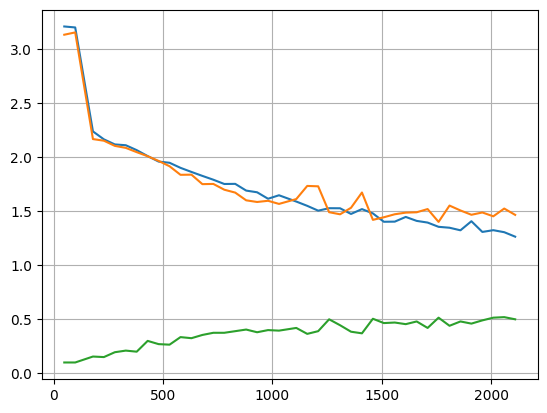

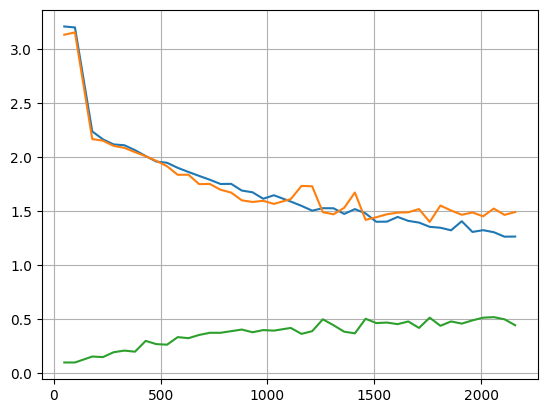

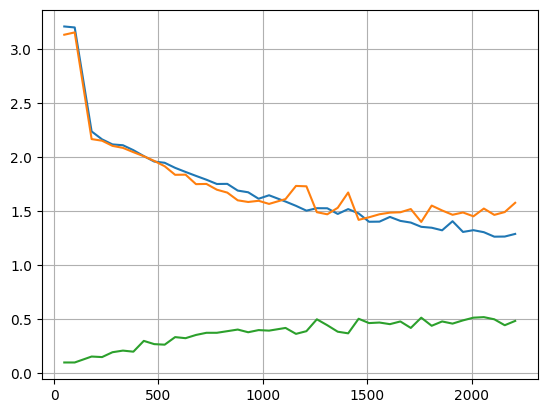

========== EPOCH 14 COMPLETED ==========


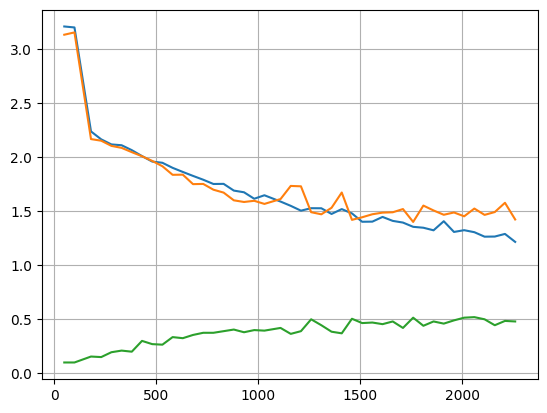

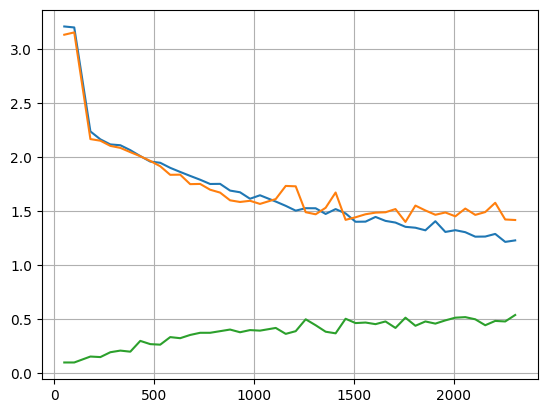

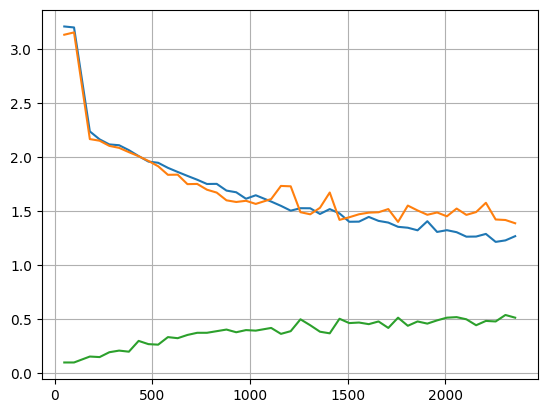

========== EPOCH 15 COMPLETED ==========


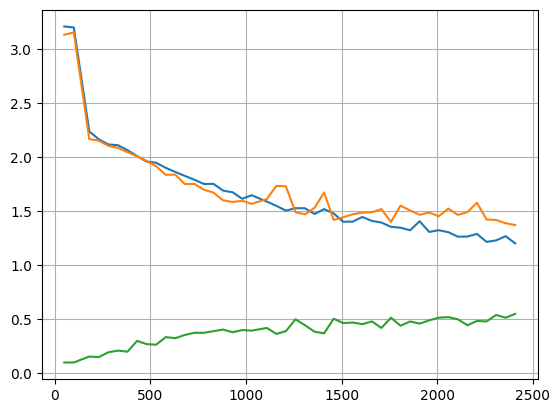

KeyboardInterrupt: 

In [364]:
losses = []
#slosses = []

for k in trange(999999):
    net.train()
    l = loss()
    #sl = sloss()
    l.backward()
    losses.append(l.item())
    slosses.append(sl.item())
    net.optim.step()
    net.zero_grad()

    if len(losses) == 50:
        vl, vacc = valloss()
        net.vlosses.append((net.iters, vl))
        net.vaccs.append((net.iters, vacc))
        net.losses.append((net.iters, np.mean(losses)))
        #net.slosses.append((net.iters, np.mean(slosses)))
        losses = []
        #slosses = []

    if k % 50 == 0:
        plt.plot(*zip(*net.losses))
        plt.plot(*zip(*net.vlosses))
        plt.plot(*zip(*net.vaccs))
        #plt.plot(*zip(*net.slosses))
        plt.grid()
        plt.show()

    net.iters += 1

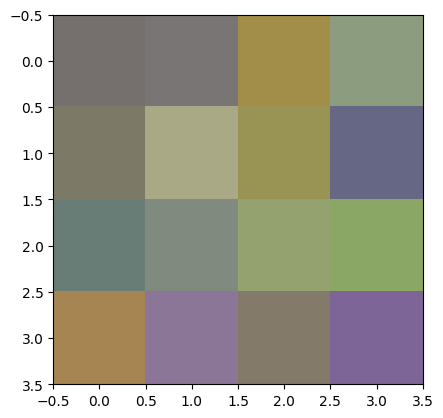

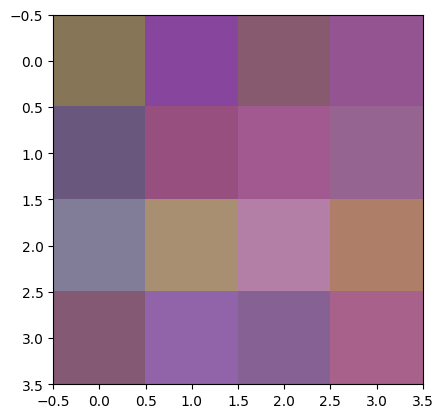

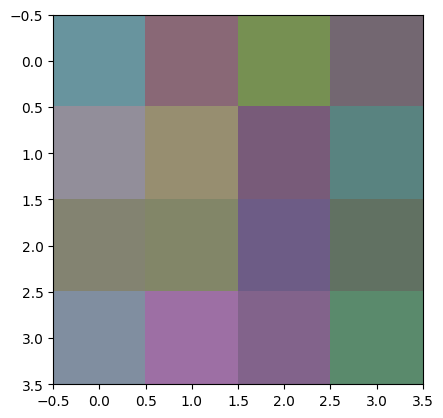

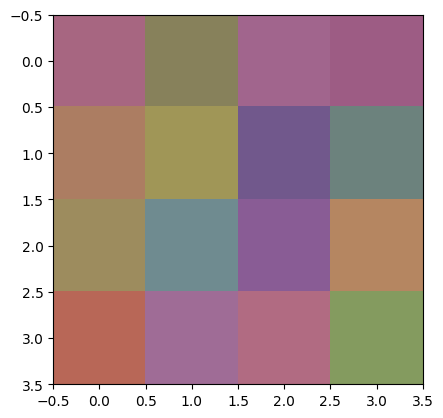

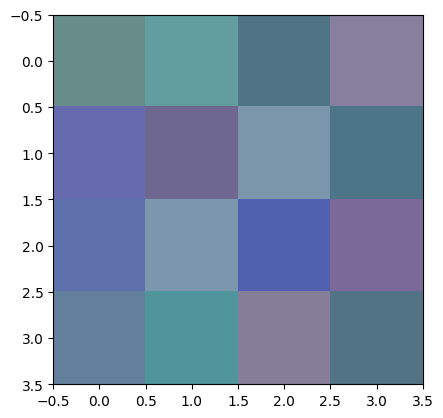

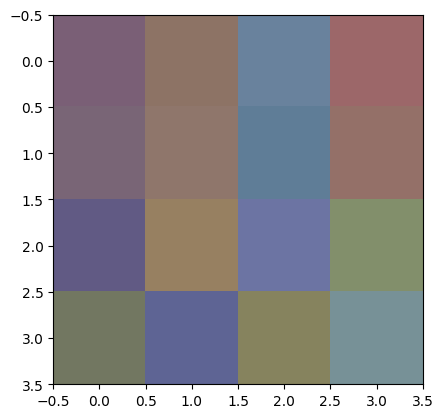

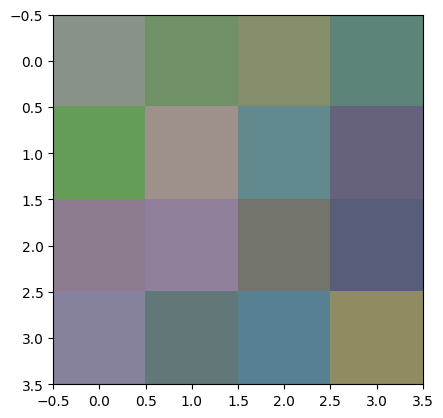

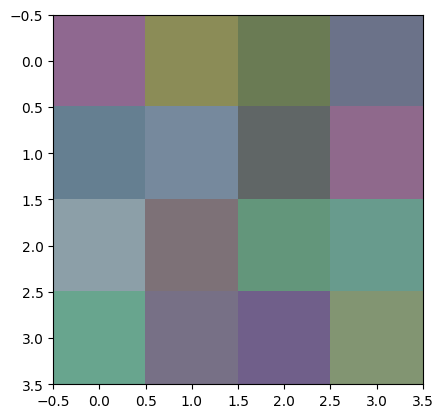

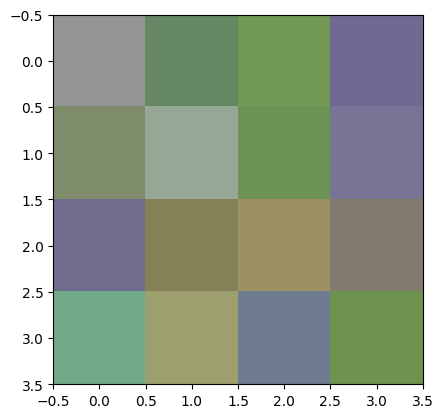

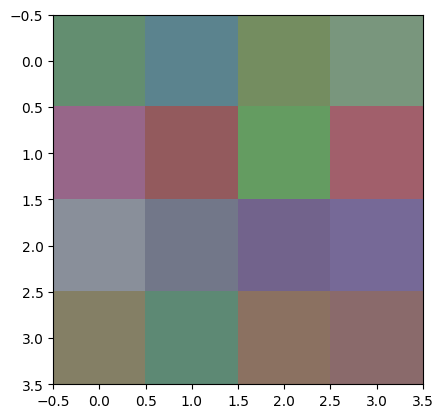

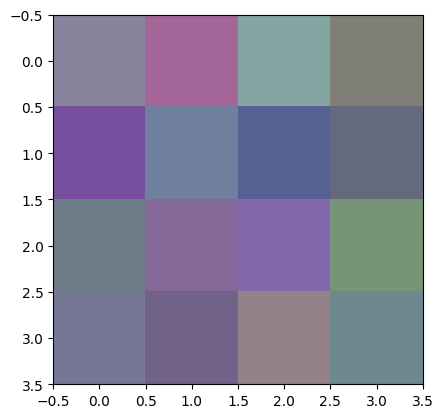

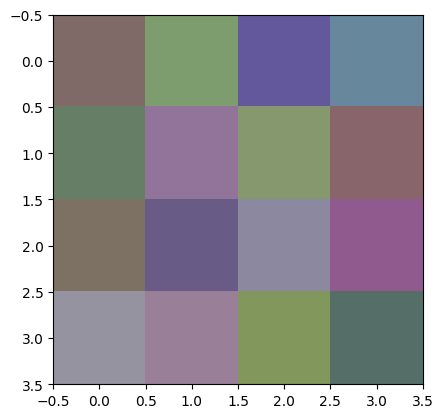

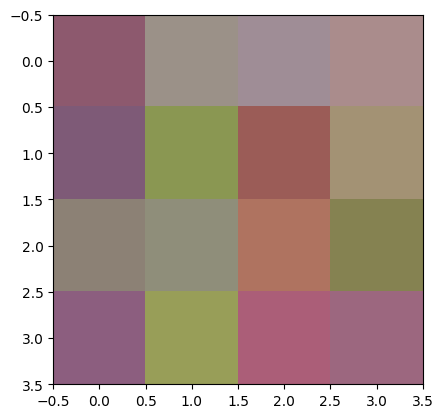

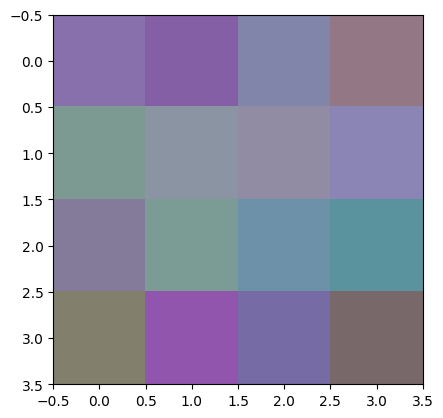

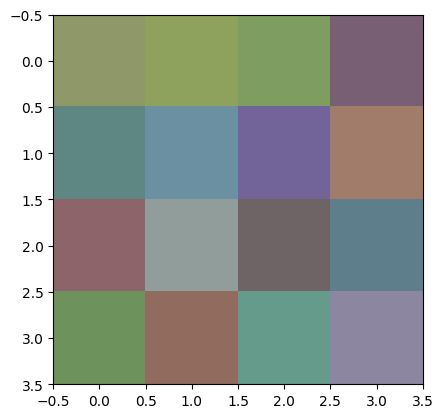

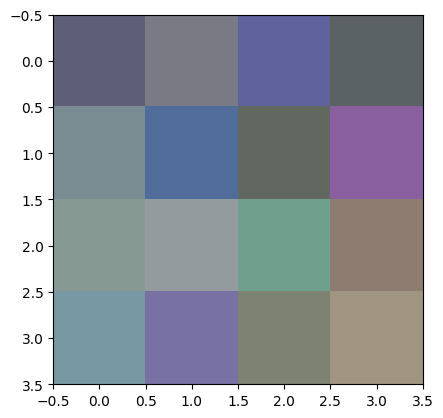

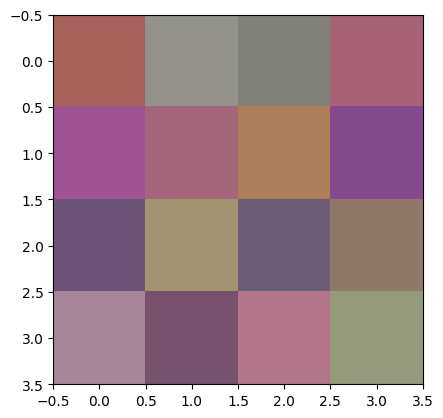

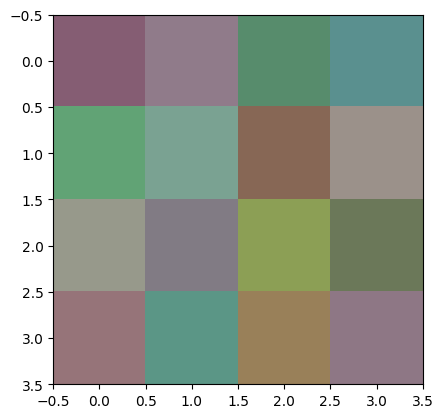

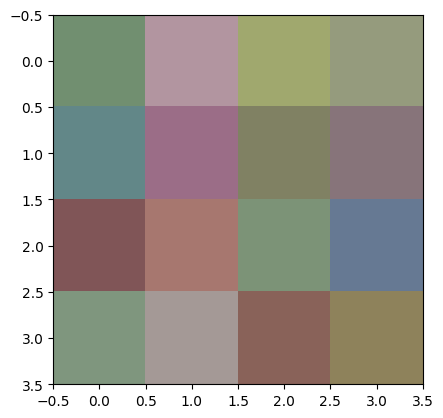

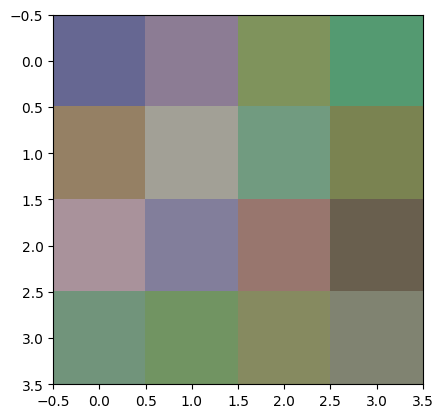

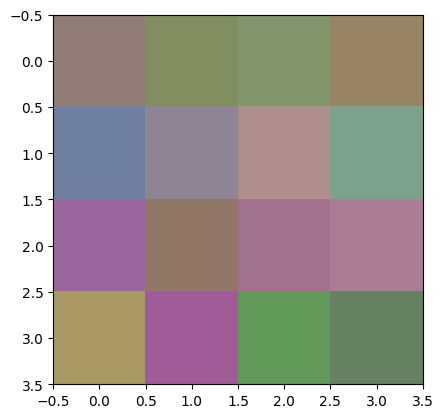

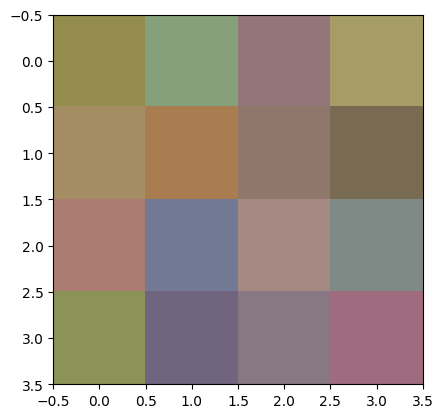

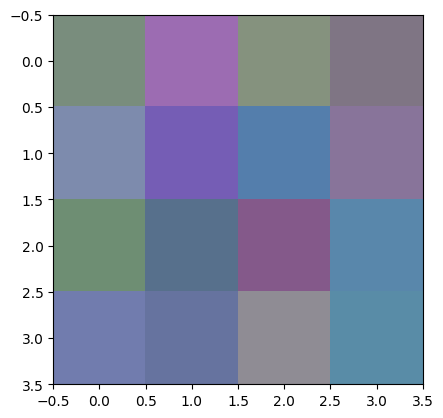

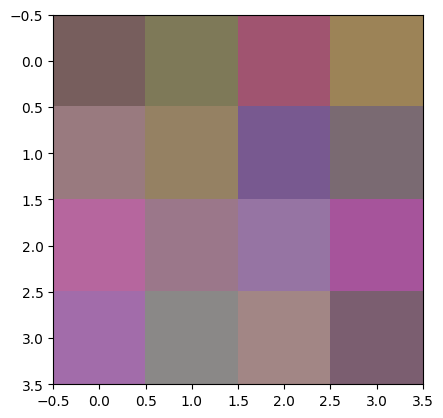

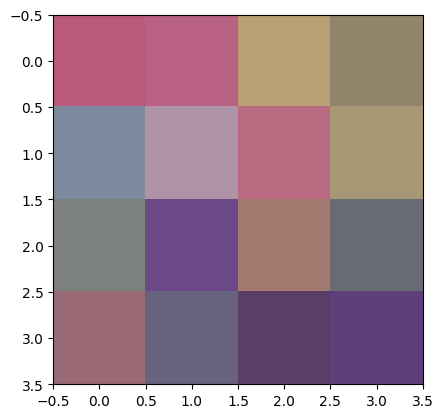

KeyboardInterrupt: 

In [363]:
for k in range(128):
    filter = t2np(net.predense.weight[k,:]).reshape((4, 4, 3))
    plt.imshow(filter +0.5)
    plt.show()